# Assignmnet 4

Generally, a parameter selection procedure might be necessary to evaluate Probability of
Detection versus Probability of False Alarm (i.e., Pd versus Pf) in order to select a classifier
model and/or select a value for a hyperparameter for a classifier.
                                                
In this assignment we will produce an ROC plot presenting operating points of various
classifiers and their varying hyperparameters so that we can make a justifiable operating
classifier/parameter selection for the following problem.

The classification of fake news or misinformation is a very important task today. Download the
fake news dataset (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset),
Fake.csv and True.csv files. Load the datasets into your model development framework and
examine the features to confirm that they are text in title and text columns. Set fake as 1
and true as 0. Concatenate the datasets together to produce one dataset of around 44,880
rows. Apply necessary pre-processing to extract the title column with Tf-Idf. (This assigns
numerical values to terms based on their frequency in a given document and throughout a
given collection of documents.) Use around 50 features. Make sure to include a sanity check in
the pipeline and perhaps run your favorite baseline classifier first.

```
df_true['class'] = 0; df_fake['class'] = 1
df = pd.concat([df_fake, df_true])
X = TfidfVectorizer(stop_words='english',
max_features=40).fit_transform(df['title'])
```

## 1. [70 pts]

By using three classifiers—decision tree, random forest, and neural network—and
at least 2 different hyperparameter settings for each, generate operating points and plot
them on a ROC. In particular, plot mean TPR and mean FPR, where the means are taken
from the multiple runs of cross-validations. Do not hesitate to use/modify the ROC plot code
in the module notebook if necessary. In case you do not see enough variety in Pd-Pf you
might need to work on the classifiers set and/or hyperparameters. And do not hesitate to try
hundreds, if necessary, since the ROC is just a natural scatter plot.
(Some recommended parameters and ranges: depth [3-12], number of features [3-20],
number of estimators [20-100], layer size [1-10], learning rate; and total of 10-20 Ops.)

In [1]:
# Load the datasets 
import pandas as pd

df_true = pd.read_csv('datasets/True.csv')
df_fake = pd.read_csv('datasets/Fake.csv')

In [2]:
# Inspect the dataset
print('\n\n\nTrue dataset head: \n',df_true.head(n=2))
print('\n\n\nFake dataset head: \n',df_fake.head(n=2))
print(f'\n\n\n{df_true.columns}')
print(f'\n\n\n{df_fake.columns}')

df_true['class'] = 0; df_fake['class'] = 1
df = pd.concat([df_fake, df_true])
print(f'\n\n\nThe columns of the final dataset are: {df.columns}')
print(f'dataframe has {len(df)} samples.')




True dataset head: 
                                                title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   



Fake dataset head: 
                                                title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  



Index(['title', 'text', 'subject', 'date'], dtype='object')



Ind

### Split the data into training and testing, and try a 

Per the assignment prompt do a sanity-- in this case check that we have the correct number of samples, approximately 44,000

In [3]:
# Transform the titles into a vector
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

MAX_FEAUTRES = 50
X = TfidfVectorizer(stop_words='english', max_features=MAX_FEAUTRES).fit_transform(df['title'])
y = df['class']
print(X.shape, y.shape)
print(f'Unique values of target vector: {y.unique()}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

(44898, 50) (44898,)
Unique values of target vector: [1 0]


### Sanity Check I have What I think I need

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
test_model = LogisticRegression()
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)
print(f'Accuracy of LogisticRegression with no tuning: {accuracy_score(y_test,y_pred)}')

Accuracy of LogisticRegression with no tuning: 0.815924276169265


### Setup paramters across several classifiers

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV, train_test_split
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

import numpy as np


clfs = {
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42),
    'neural_network': Perceptron(random_state=42)
}
param_dict = {
    'halving_search': {
        'decision_tree': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'splitter': ['best', 'random'],
            'max_depth': [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37],
            'ccp_alpha': np.linspace(0.01, 5, 10),
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'random_forest': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37],
            'ccp_alpha': np.linspace(0.01, 5, 10),
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'neural_network': {
            'random_state': [None, 42],
            'penalty': ['l2', 'l1', 'elasticnet', None],
            'eta0': np.linspace(.5, 10, 100),
            'early_stopping': [True, False],
            'validation_fraction': np.linspace(0, 1, 50),
            'l1_ratio': np.linspace(0.01, 0.3, 50)
        }
    },
    'grid_search': {
        'decision_tree': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'splitter': ['best', 'random'],
            'max_depth': [2, 3, 5, 7, 11, 13],
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'random_forest': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [2, 3, 5, 7, 11, 13],
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'neural_network': {
            'random_state': [None, 42],
            'penalty': ['l2', 'l1', 'elasticnet', None],
            'eta0': np.linspace(.5, 5, 10),
            'early_stopping': [True, False],
            'validation_fraction': np.linspace(0.01, 1, 5)
        }
    }
}

### Get the best hyperparameters for each model

Note: after testing with GridSeach, and the amount of params I put in, the timespace was untenable. 

In [8]:
bests = {}
for k in clfs.keys():
    print(f'\n\n\nrunning halving random search for {k}')
    hs = HalvingRandomSearchCV(clfs[k], param_dict['halving_search'][k], cv=5, scoring='f1_weighted', error_score=0.0, n_jobs=-1, verbose=1)
    hs.fit(X_train, y_train)
    bests[k+'__HalvingSearch'] = { 
                'best_model': hs.best_estimator_,
                'best_accuracy': hs.best_estimator_.score(X_test, y_test),
                'best_params': hs.best_params_,
                'best_score': hs.best_score_
            }
    # print(f'\n\n\nrunning grid search for {k}')
    # gs = GridSearchCV(clfs[k], param_dict['grid_search'][k], cv=5, scoring='accuracy', n_jobs=8, verbose=1)
    # gs.fit(X_train, y_train)
    # bests[k+'__GridSearch'] = { 
    #             'best_model': gs.best_estimator_,
    #             'best_accuracy': gs.best_estimator_.score(X_test, y_test),
    #             'best_params': gs.best_params_,
    #             'best_score': gs.best_score_
    #         }
    




running halving random search for decision_tree
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 20
max_resources_: 35918
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1795
n_resources: 20
Fitting 5 folds for each of 1795 candidates, totalling 8975 fits
----------
iter: 1
n_candidates: 599
n_resources: 60
Fitting 5 folds for each of 599 candidates, totalling 2995 fits
----------
iter: 2
n_candidates: 200
n_resources: 180
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
----------
iter: 3
n_candidates: 67
n_resources: 540
Fitting 5 folds for each of 67 candidates, totalling 335 fits
----------
iter: 4
n_candidates: 23
n_resources: 1620
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 5
n_candidates: 8
n_resources: 4860
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 3
n_resources: 14580
Fitting 5 folds for each of 3 candidates, totallin

/home/ace/work/JHU-AppliedML-EN705601-SP25/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1220 fits failed out of a total of 8975.
The score on these train-test partitions for these parameters will be set to 0.0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "/home/ace/work/JHU-AppliedML-EN705601-SP25/venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ace/work/JHU-AppliedML-EN705601-SP25/venv/lib/python3.12/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/hom

----------
iter: 1
n_candidates: 599
n_resources: 60
Fitting 5 folds for each of 599 candidates, totalling 2995 fits
----------
iter: 2
n_candidates: 200
n_resources: 180
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
----------
iter: 3
n_candidates: 67
n_resources: 540
Fitting 5 folds for each of 67 candidates, totalling 335 fits
----------
iter: 4
n_candidates: 23
n_resources: 1620
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 5
n_candidates: 8
n_resources: 4860
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 3
n_resources: 14580
Fitting 5 folds for each of 3 candidates, totalling 15 fits


### For my own sake print the best parts of each model

In [9]:
for k_clf, clf_scores in bests.items():
    print(f'For {str(k_clf).replace('__HalvingSearch',' with halving random search').replace('__GridSearch',' with grid search')} achieved')
    for k, v in clf_scores.items():
        print(f'\t\t{k}: {v}')
    print()
    print()
        

For decision_tree with halving random search achieved
		best_model: DecisionTreeClassifier(ccp_alpha=np.float64(0.01), criterion='entropy',
                       max_depth=29, min_samples_leaf=0.01, splitter='random')
		best_accuracy: 0.7571269487750557
		best_params: {'splitter': 'random', 'random_state': None, 'min_samples_leaf': 0.01, 'max_features': None, 'max_depth': 29, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.01)}
		best_score: 0.7450845394703173


For random_forest with halving random search achieved
		best_model: RandomForestClassifier(ccp_alpha=np.float64(0.01), criterion='entropy',
                       max_depth=5, max_features='log2', min_samples_leaf=0.01,
                       random_state=42)
		best_accuracy: 0.7846325167037862
		best_params: {'random_state': 42, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 5, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.01)}
		best_score: 0.7697183069441698


For neural_network with halving random sea

In [16]:
# Display OP
def annot(opi, _x, _y):
    plt.annotate(f"OP{opi}", xy=(_x, _y), xytext=(.90*_x+.1, .80*_y), arrowprops=dict(facecolor='lightgray', shrink=1))

def plotter(TPR, FPR, model_name):
    fpr = [0.]+list(FPR)+[1.]; tpr = [0.]+list(TPR)+[1.]

    # Plot
    fig, ax = plt.subplots(dpi=72)
    plt.plot(fpr, tpr, ':', label='ROC')
    plt.scatter(FPR, TPR, 50, color='red', marker='o', label='operating points')
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')
    
    # Annotate certain operating points
    annot(1, fpr[1], tpr[1])
    annot(2, fpr[4], tpr[4])
    annot(3, fpr[8], tpr[8])
    annot(4, fpr[9], tpr[9])
    
    # Labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(model_name)
    plt.legend(loc='lower right')
    plt.grid()
    # plt.show()

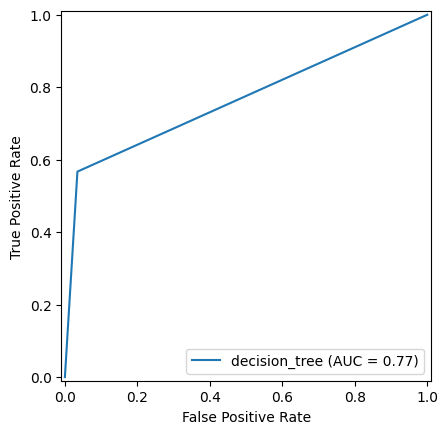

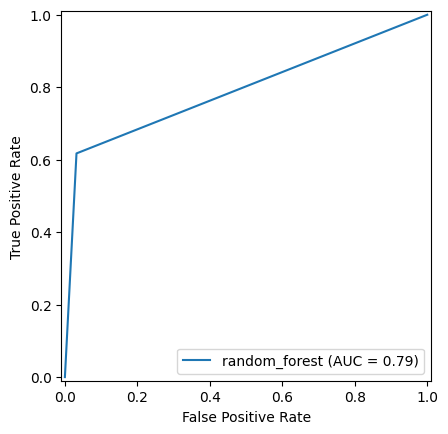

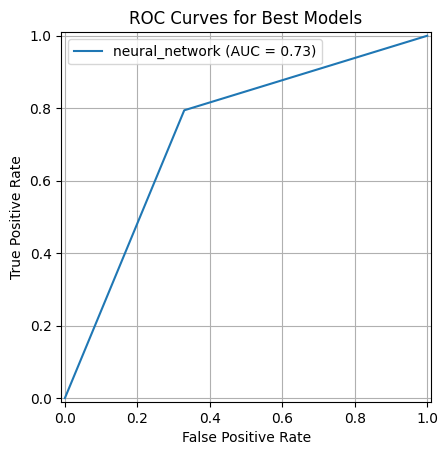

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, confusion_matrix, RocCurveDisplay, roc_curve

roc_plots = []
for k_clf, clf_scores in bests.items():
    FPR, TPR = [], []
    model_name = k_clf.replace('__HalvingSearch','').replace('__GridSearch','')
    y_pred = clf_scores['best_model'].predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=model_name)
    display.plot()
    

plt.title("ROC Curves for Best Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

## 2. [10 pts] 

What kind of behavior would you expect to see in Pd - Pf interaction of an ROC plot? Do you see it in yours? (Hint: Pd and Pf correspond to TPR and FPR.)


### Answer

To clarify-- `Pd` is "True Positive Rate" and `Pf` is "False Positive Rate." All the ROC graphs we've looked at progress from (0,0) to (1,1), which is what my curves do.   Also, as we increase TPR (`Pd`) we tend to capture more FPR (`Pf`), which is what my graphs exhibit.

## 3. [10 pts]

From the ROC plot that you created make a selection of the classifier and hyperparameter setting for this problem and then justify the selection. Note that we are classifying fake news so your conclusion might be subjective but has to be supported by your findings.


### Answers

I'm choosing the estimator that has the highest accuracy, 78%, and best weighted F1-score. This means calculating F-1 for each label and finding their average "true" instances per label.

Estimator: random forest

Hyper parameters: 
- random_state: 42
- min_samples_leaf: 0.01
- max_features: log2
- max_depth: 5
- criterion: entropy
- ccp_alpha: np.float64(0.01)

## 4. [10 pts]

Try adding text column to the features (again with Tf-Idf). Choose any classifier model to train on this new and improved dataset and report on its performance. Why do you think the performance is much higher than the previous one which only uses title column?